# Distributed Optimization with the Alternating Direction Method of Multipliers

In this lecture we will see the how the ADMM algorithm can be used for distributed optimization. Using the notatation from the course slides, we aim to solve the following optimization problem

![](ADMM_problem.png)


The algorithm is described by the following iteration:

![](ADMM_algorithm.png)

where the first N updates can be done in parallel.


## Structure of this session:

   * ADMM with 1 split (sequential algorithm).
   * ADMM with 2 splits or more.
   * Parallelize the splitting algorithm in Python using multiprocessing.
   * We will see one application of the lasso, that of tomography reconstruction. 
   

![](tomography.png)


## References

* [DSOML course notes](http://marcocuturi.net/Teaching/ENSAE/2017/DSOML/DSOML5.pdf)

* [Distributed Optimization and Statistical
Learning via the Alternating Direction
Method of Multipliers](http://stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf), S. Boyd et al. 2010

In [1]:
# .. needed imports ..
import numpy as np
%pylab inline
# import numpy as np

Populating the interactive namespace from numpy and matplotlib




# Practical session: Lasso problem

We will now use ADMM to solve a nonsmooth optimization problem.


The Lasso is staistical model that has found many applications in machine learning, signal processing, biomedical imaging and genetics, to name a few. Given a regression dataset $A \in \mathbb{R}^{n \times p}, b \in \mathbb{R}^n$, the Lasso is determined as the solution to the optimization problem

$$\text{argmin}_{\theta} \frac{1}{2n}\|A \theta - b\|^2 + \lambda \|\theta\|_1 \quad,$$
where $\lambda$ is a regularization parameter. The Lasso model is so useful because, given enough regularization, it gives solutions which are *sparse*, i.e., with many zero coefficients.



# Part 1: a simple implementation

We can reformulate the Lasso problem in the following equivalent form
$$
\begin{aligned}
&\text{argmin}_{\theta} \frac{1}{2n}\|A \theta - b\|^2 + \lambda \|\rho\|_1 \quad,\\
&\text{ subject to }~ \theta=\rho
\end{aligned}
$$

Now that we have written it in ADMM-friendly fashion, we can use the the above algorithm with $N=1$. This gives the following iteration:
$$
\begin{aligned}
&\theta^{t+1} = \text{argmin}_{\theta} \frac{1}{2n}\|A \theta - b\|^2 + \frac{\tau}{2}\|\theta - \rho^t + u^t\|^2 \\
&\rho^{t+1} = \text{argmin}_{\theta} \lambda \|\theta\|_1 + \frac{\tau}{2} \|\theta - \theta^{t+1} - u^t\|^2\\
& u^{t+1} = u^t + \theta^{t+1} - \rho^{t+1}
\end{aligned}
$$

It turns that for this particular problem many of the steps have a closed form solution. Using this we have the following closed form updates:
$$
\begin{aligned}
&\theta^{t+1} = \frac{1}{n}(A^T A / n + \tau I)^{-1}(A^T b / n + \tau (\rho^t - u^t)) \\
&\rho^{t+1} = (\theta^{t+1} + u^t - \frac{\tau}{\lambda})_+ - (\frac{\tau}{\lambda} - \theta^{t+1} - u^t)_+\\
& u^{t+1} = u^t + \theta^{t+1} - \rho^{t+1}
\end{aligned}
$$

where $(\cdot)_+$ denote the positive part, i.e., $(x)_+ := \text{max}(x, 0)$.



In [2]:

# .. create some fake data ..
np.random.seed(0)

n_samples, n_features = 100, 100
A = np.random.randn(n_samples, n_features)
w = np.random.randn(n_features)
b = A.dot(w) + np.random.randn(n_samples)

def obj_fun(theta, A, b, lamb):
    # .. the lasso objective function ..
    loss = (0.5 / n_samples) * np.sum(np.linalg.norm(A.dot(theta) - b)**2)
    return loss + lamb * np.sum(np.abs(theta))

def lasso_ADMM(A, b, max_iter=100, lam=1.):
    # .. initialize variables ..
    tau = 1.
    n_samples, n_features = A.shape
    rho = np.zeros(n_features)
    u = np.zeros(n_features)

    # .. to keep track of progress ..
    obj_fun_history = []

    # .. cache inverse matrix ..
    AtA_inv = np.linalg.pinv(A.T.dot(A) / n_samples + tau * np.eye(n_features))
    for i in range(max_iter):
        theta = AtA_inv.dot(A.T.dot(b) / n_samples + tau * (rho - u))
        rho = np.fmax(theta + u - lam /tau, 0) - np.fmax(-lam/tau - theta - u, 0)
        u = u + theta - rho
        obj_fun_history.append(obj_fun(theta, A, b, lam))

    return theta, obj_fun_history
    
theta, func_vals = lasso_ADMM(A, b)

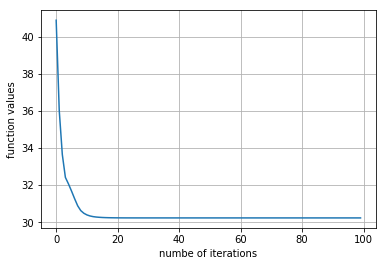

In [3]:
# lets plot the objective values of the function
# to make sure it has converged
plt.plot(func_vals)
plt.ylabel('function values')
plt.xlabel('numbe of iterations')
plt.grid()
plt.show()

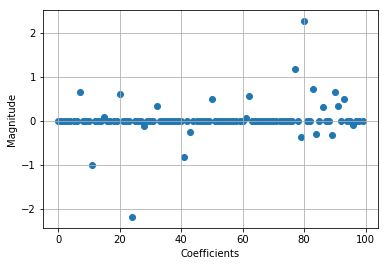

In [4]:
# let's also look at the coefficients of the solution
plt.scatter(np.arange(len(theta)), theta)
plt.ylabel('Magnitude')
plt.xlabel('Coefficients')
plt.grid()
plt.show()

They are **sparse**, i.e., with many coefficients set exactly to zero.

In the above example, both steps are closed form but this is not necessarily the case. For example, in the case of L1-regularized logistic regression,
$$
    \text{argmin}_{\theta} \frac{1}{n} \sum_{i=1}^n -\log(1 + e^{-b_i a_i^T x})
$$


<span style="color: red; font-weight: bold">Exercise (10 min): Logistic Regression. Adapt the above code to optimize an L1 regularized logistic regression (i.e. when the loss is the logistic loss instead of the squared loss).</span>


In [5]:
from scipy import optimize

# .. make b be {-1, 1} since its a classification problem ..
b = np.sign(A.dot(w) + np.random.randn(n_samples))


def logistic_loss(theta):
    p = b * A.dot(theta)
    t = 1.0 + np.exp(-p)
    return -np.sum(np.log(1.0 / t))


def logistic_grad(x):
    t = b * A.dot(x)
    z = 1. / (1 + np.exp(-t))
    z0 = (z - 1) * b
    grad_w = A.T.dot(z0) 
    return grad_w


# this solves the logistic regression problem
# from scipy import optimize
sol = optimize.minimize(logistic_loss, np.zeros(n_features), jac=logistic_grad)
print('sol.x is a solution to the logistic regression problem')


sol.x is a solution to the logistic regression problem


# Part 2: more than one split

We will now use ADMM to actually do some distributed computations. For this we can split the first subproblem into two ($N=2$) and using the ADMM algorithm specified at the beginning.


In [6]:


def lasso_ADMM_2(A, b, max_iter=100, lam=1.):

    # .. split current dataset ..
    A_1, A_2 = np.array_split(A, 2)
    b_1, b_2 = np.array_split(b, 2)

    # .. initialize variables ..
    tau = 1.
    n_samples, n_features = A.shape
    rho = np.zeros(n_features)
    u_1 = np.zeros(n_features)
    u_2 = np.zeros(n_features)

    # .. to keep track of progress ..
    obj_fun_history = []

    # .. cache inverse matrix ..
    AtA_1_inv = np.linalg.pinv(A_1.T.dot(A_1) / n_samples + tau * np.eye(n_features))
    AtA_2_inv = np.linalg.pinv(A_2.T.dot(A_2) / n_samples + tau * np.eye(n_features))

    for i in range(max_iter):
        theta_1 = AtA_1_inv.dot(A_1.T.dot(b_1) / n_samples + tau * (rho - u_1))
        theta_2 = AtA_1_inv.dot(A_2.T.dot(b_2) / n_samples + tau * (rho - u_2))
        u = (u_1 + u_2) / 2.
        theta = (theta_1 + theta_2) / 2.
        rho = np.fmax(theta + u - lam /tau, 0) - np.fmax(-lam/tau - theta - u, 0)
        u_1 = u_1 + theta_1 - rho
        u_2 = u_2 + theta_2 - rho
        obj_fun_history.append(obj_fun(theta_1, A, b, lam))

    return theta, obj_fun_history

theta_1, func_vals = lasso_ADMM_2(A, b)

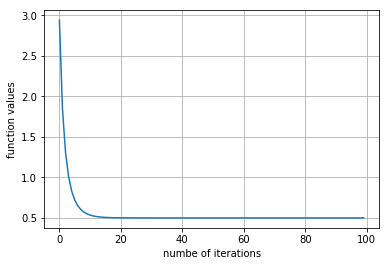

In [7]:
# lets plot the objective values of the function
# to make sure it has converged
plt.plot(func_vals)
plt.ylabel('function values')
plt.xlabel('numbe of iterations')
plt.grid()
plt.show()

<span style="color: red; font-weight: bold">Exercise (10 min): Extend this to ar arbitrary number of splits.</span>

We will now use the multiprocessing library in the Python standard library to perform the theta_1 and theta_2 steps in parallel

In [12]:
import concurrent.futures

def _compute_inverse(A_1, tau, n_features):
    return np.linalg.pinv(A_1.T.dot(A_1) / n_samples + tau * np.eye(n_features))

def _compute_theta(AtA_inv, A, b, tau, rho, u):
    return AtA_inv.dot(A.T.dot(b) / n_samples + tau * (rho - u))

def lasso_ADMM_2_MP(A, b, max_iter=100, lam=1.):

    # .. split current dataset ..
    A_1, A_2 = np.array_split(A, 2)
    b_1, b_2 = np.array_split(b, 2)

    # .. initialize variables ..
    tau = 1.
    n_samples, n_features = A.shape
    rho = np.zeros(n_features)
    u_1 = np.zeros(n_features)
    u_2 = np.zeros(n_features)

    # .. to keep track of progress ..
    obj_fun_history = []

    
    futures = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures.append(executor.submit(_compute_inverse, A_1, tau, n_features))
        futures.append(executor.submit(_compute_inverse, A_1, tau, n_features))    
    concurrent.futures.wait(futures)

    AtA_1_inv = futures[0].result()
    AtA_2_inv = futures[1].result()


    for i in range(max_iter):
        futures = []
        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures.append(executor.submit(_compute_theta, AtA_1_inv, A_1, b_1, tau, rho, u_1))
            futures.append(executor.submit(_compute_theta, AtA_2_inv, A_2, b_2, tau, rho, u_2))
        concurrent.futures.wait(futures)
        theta_1 = futures[0].result()
        theta_2 = futures[1].result()
        theta = (theta_1 + theta_2) / 2.
        u = (u_1 + u_2) / 2.
        rho = np.fmax(theta + u - lam /tau, 0) - np.fmax(-lam/tau - theta - u, 0)
        u_1 = u_1 + theta_1 - rho
        u_2 = u_2 + theta_2 - rho
        obj_fun_history.append(obj_fun(theta_1, A, b, lam))

    return theta, obj_fun_history

theta_1, func_vals = lasso_ADMM_2_MP(A, b)


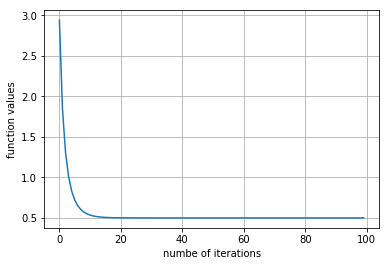

In [13]:
# lets plot the objective values of the function
# to make sure it has converged
plt.plot(func_vals)
plt.ylabel('function values')
plt.xlabel('numbe of iterations')

plt.grid()
plt.show()

## Compressive sensing application: tomography reconstruction with the Lasso


This example shows the reconstruction of an image from a set of parallel projections, acquired along different angles. Such a dataset is acquired in computed tomography (CT).

Without any prior information on the sample, the number of projections required to reconstruct the image is of the order of the linear size l of the image (in pixels). For simplicity we consider here a sparse image, where only pixels on the boundary of objects have a non-zero value. Such data could correspond for example to a cellular material. Note however that most images are sparse in a different basis, such as the Haar wavelets. Only l/7 projections are acquired, therefore it is necessary to use prior information available on the sample (its sparsity): this is an example of compressive sensing.

The tomography projection operation is a linear transformation. In addition to the data-fidelity term corresponding to a linear regression, we penalize the L1 norm of the image to account for its sparsity. **The resulting optimization problem is called the Lasso**.


The reconstruction with L1 penalization should give a result with zero error (all pixels are successfully labeled with 0 or 1), even if noise was added to the projections. In comparison, an L2 penalization (sklearn.linear_model.Ridge) produces a large number of labeling errors for the pixels. Important artifacts are observed on the reconstructed image, contrary to the L1 penalization. Note in particular the circular artifact separating the pixels in the corners, that have contributed to fewer projections than the central disk.


<span style="color: red; font-weight: bold">Exercise (10 min). I have done the image reconstruction using Ridge regression, do it using the lasso algorithm previously coded.</span>

In [14]:
import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """ Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator.toarray()


def generate_synthetic_data():
    """ Synthetic binary data """
    rs = np.random.RandomState(0)
    n_pts = 12.
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2) ** 2 + (y - l / 2) ** 2 < (l / 2) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return res - ndimage.binary_erosion(res)


# Generate synthetic images, and projections
l = 32
proj_operator = build_projection_operator(l, l / 5.)
data = generate_synthetic_data()
y = proj_operator.dot(data.ravel()[:, np.newaxis])
y += 0.15 * np.random.randn(*y.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, y.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

/Users/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:68: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


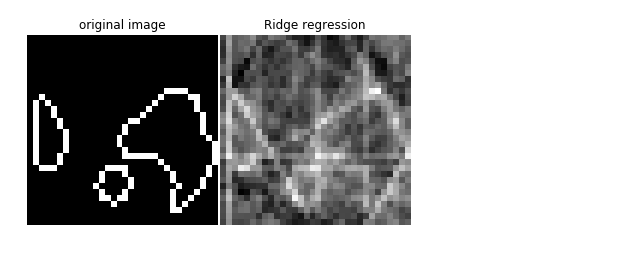

In [15]:

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Ridge regression')
plt.axis('off')
plt.subplot(133)

plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)

plt.show()